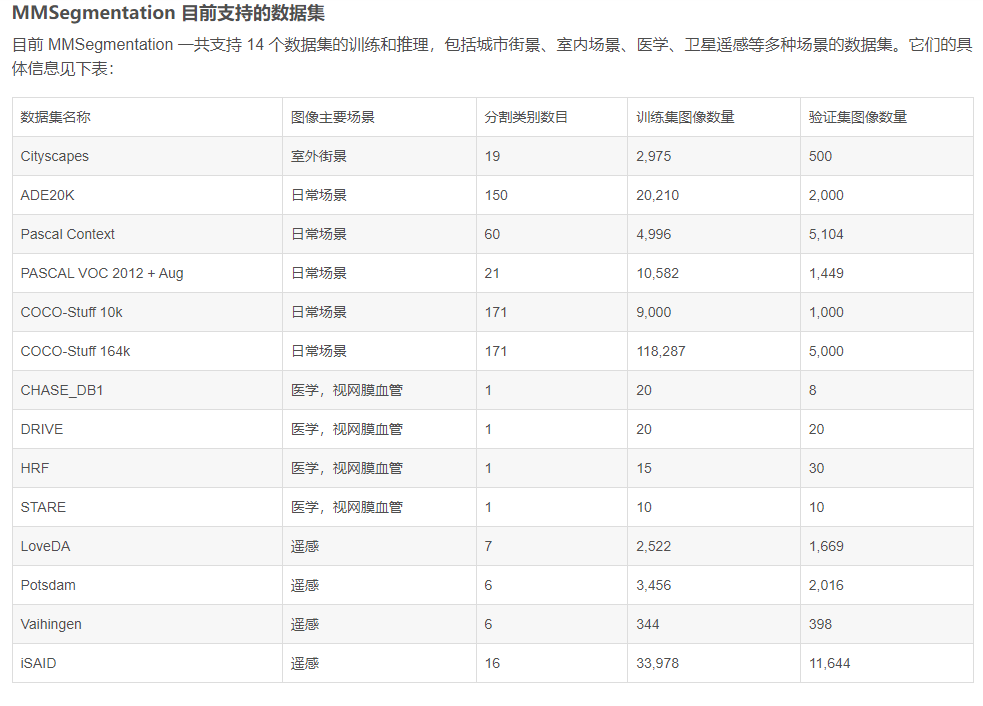

### 1. 准备config配置文件
### 1.1 定义数据集类（各类别名称及配色）

`!rm -rf mmseg/datasets/DubaiDataset.py # 删除原有文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset.py -P mmseg/datasets`

- Create folders (mmseg\datasets) under data folder
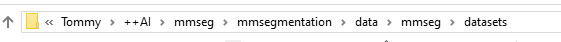
-Download py Files
    - Download https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset.py and put int the datasets folder
    - download https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/__init__.py and put int the datasets folder
    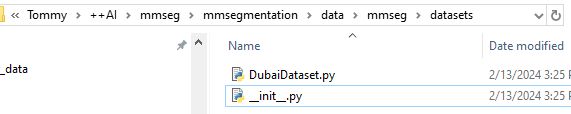

- 定义训练及测试pipeline
    - download https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset_pipeline.py
    - move the python file to "configs/_base_/datasets"
- 下载模型config配置文件
    - download https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/pspnet_r50-d8_4xb2-40k_DubaiDataset.py
    - move to folder "configs/pspnet"

In [8]:
import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline

### 2. 载入config配置文件

In [9]:
from mmengine import Config
cfg = Config.fromfile(r'D:\Tommy\++AI\mmseg\mmsegmentation\configs\pspnet\pspnet_r50-d8_4xb2-40k_DubaiDataset.py')

### 3. 修改config配置文件

In [16]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

# 模型 decode/auxiliary 输出头，指定为类别个数
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6

cfg.train_dataloader.batch_size = 8

cfg.test_dataloader = cfg.val_dataloader

# 结果保存目录
cfg.work_dir = 'D:\Tommy\++AI\mmseg\mmsegmentation\data\work_dirs\DubaiDataset'

# 训练迭代次数
cfg.train_cfg.max_iters = 3000
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 1500

# 随机数种子
cfg['randomness'] = dict(seed=0)

In [17]:
print(cfg.pretty_text)

crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        64,
        64,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'Dubai-dataset/'
dataset_type = 'DubaiDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=1500, type='CheckpointHook'),
    logger=dict(interval=100, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
load_from = 

### 4. 保存config配置文件

In [18]:
cfg.dump(r'D:\Tommy\++AI\mmseg\mmsegmentation\data\pspnet-DubaiDataset_20230612.py')

## MMSegmentation训练语义分割模型

### 1. Train

In [19]:
import numpy as np

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine

from mmengine import Config
cfg = Config.fromfile(r'D:\Tommy\++AI\mmseg\mmsegmentation\data\pspnet-DubaiDataset_20230612.py')
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

In [20]:
#cfg['data_root']= 'D:\\Tommy\\++AI\\mmseg\\mmsegmentation\\data\\Dubai-dataset\\'

In [21]:
# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

runner.train()

02/13 16:50:10 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: Quadro RTX 4000
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.55
    MSVC: n/a, reason: fileno
    PyTorch: 1.13.1
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192829337
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code

02/13 16:50:21 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/13 16:50:21 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

02/13 16:59:07 - mmengine - INFO - Iter(train) [1100/3000]  lr: 9.7549e-03  eta: 0:14:22  time: 0.4546  data_time: 0.0036  memory: 4004  loss: 0.0751  decode.loss_ce: 0.0533  decode.acc_seg: 73.1201  aux.loss_ce: 0.0218  aux.acc_seg: 72.1313
02/13 16:59:52 - mmengine - INFO - Iter(train) [1200/3000]  lr: 9.7325e-03  eta: 0:13:36  time: 0.4476  data_time: 0.0035  memory: 4004  loss: 0.0648  decode.loss_ce: 0.0454  decode.acc_seg: 66.8213  aux.loss_ce: 0.0194  aux.acc_seg: 68.0878
02/13 16:59:57 - mmengine - INFO - per class results:
02/13 16:59:57 - mmengine - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
|    Land    |  56.9 | 98.09 |
|    Road    |  7.36 |  7.49 |
|  Building  |  1.21 |  1.21 |
| Vegetation | 10.72 | 11.01 |
|   Water    | 29.57 | 35.24 |
| Unlabeled  |  0.0  |  0.0  |
+------------+-------+-------+
02/13 16:59:57 - mmengine - INFO - Iter(val) [15/15]    aAcc: 58.5500  mIoU: 17.6300  mAcc: 25.5100  data_time: 0.00

02/13 17:13:52 - mmengine - INFO - Saving checkpoint at 3000 iterations


EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

### 2. Check the Log and Results

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
#Load from log
log_path = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\work_dirs\DubaiDataset\20240213_164054\vis_data\scalars.json'
with open(log_path, "r") as f:
    json_list = f.readlines()
len(json_list)

eval(json_list[4])

df_train = pd.DataFrame()
df_test = pd.DataFrame()
for each in json_list[:-1]:
    print(each)
    if 'aAcc' in each:
        df_test = pd.concat([df_test, pd.DataFrame.from_dict(eval(each), orient='index').T], ignore_index=True)
    else:
        df_train = pd.concat([df_train, pd.DataFrame.from_dict(eval(each), orient='index').T], ignore_index=True)

{"lr": 0.009998440697372778, "data_time": 0.7347947061061859, "loss": 0.1534715723246336, "decode.loss_ce": 0.10928487312048674, "decode.acc_seg": 44.2230224609375, "aux.loss_ce": 0.04418669827282429, "aux.acc_seg": 42.169189453125, "time": 1.4790131449699402, "iter": 8, "memory": 4774, "step": 8}

{"lr": 0.00997794446709763, "data_time": 0.003691434860229492, "loss": 0.10492395386099815, "decode.loss_ce": 0.07319988757371902, "decode.acc_seg": 75.5615234375, "aux.loss_ce": 0.031724066101014615, "aux.acc_seg": 71.2310791015625, "time": 0.4249063730239868, "iter": 100, "memory": 4004, "step": 100}

{"lr": 0.009955660594668054, "data_time": 0.004582619667053223, "loss": 0.09951866865158081, "decode.loss_ce": 0.07028831206262112, "decode.acc_seg": 50.1983642578125, "aux.loss_ce": 0.029230355657637118, "aux.acc_seg": 51.0406494140625, "time": 0.4318902254104614, "iter": 200, "memory": 4004, "step": 200}

{"lr": 0.009933371122565919, "data_time": 0.004596209526062012, "loss": 0.093371385335

In [34]:
#export tables of training log
df_train.to_csv( r'D:\Tommy\++AI\mmseg\mmsegmentation\data\训练日志-训练集.csv', index=False)
df_test.to_csv( r'D:\Tommy\++AI\mmseg\mmsegmentation\data\训练日志-测试集.csv', index=False)

In [35]:
#Visual Results
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

### 2.1 训练集损失函数

C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\2555024489.py:12: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.savefig('训练集损失函数.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\2555024489.py:12: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.savefig('训练集损失函数.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\2555024489.py:12: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from current font.
  plt.savefig('训练集损失函数.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\2555024489.py:12: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.savefig('训练集损失函数.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\2555024489.py:12: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current 

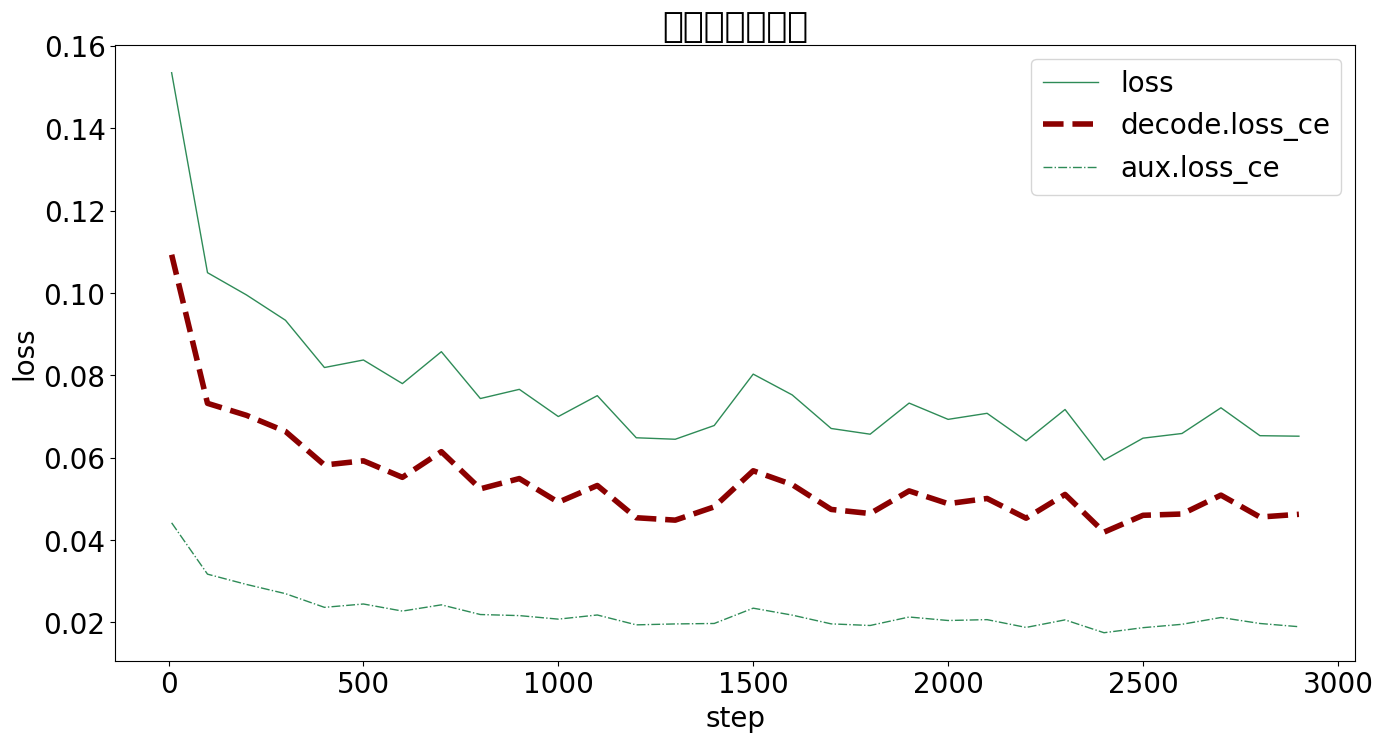

In [36]:
metrics = ['loss', 'decode.loss_ce', 'aux.loss_ce']
plt.figure(figsize=(16, 8))

x = df_train['step']
for y in metrics:
    plt.plot(x, df_train[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('训练集损失函数', fontsize=25)
plt.savefig('训练集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

### 2.2 训练集准确率

C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\2287259432.py:11: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.savefig('训练集准确率.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\2287259432.py:11: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.savefig('训练集准确率.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\2287259432.py:11: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from current font.
  plt.savefig('训练集准确率.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\2287259432.py:11: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.savefig('训练集准确率.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\2287259432.py:11: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from current font

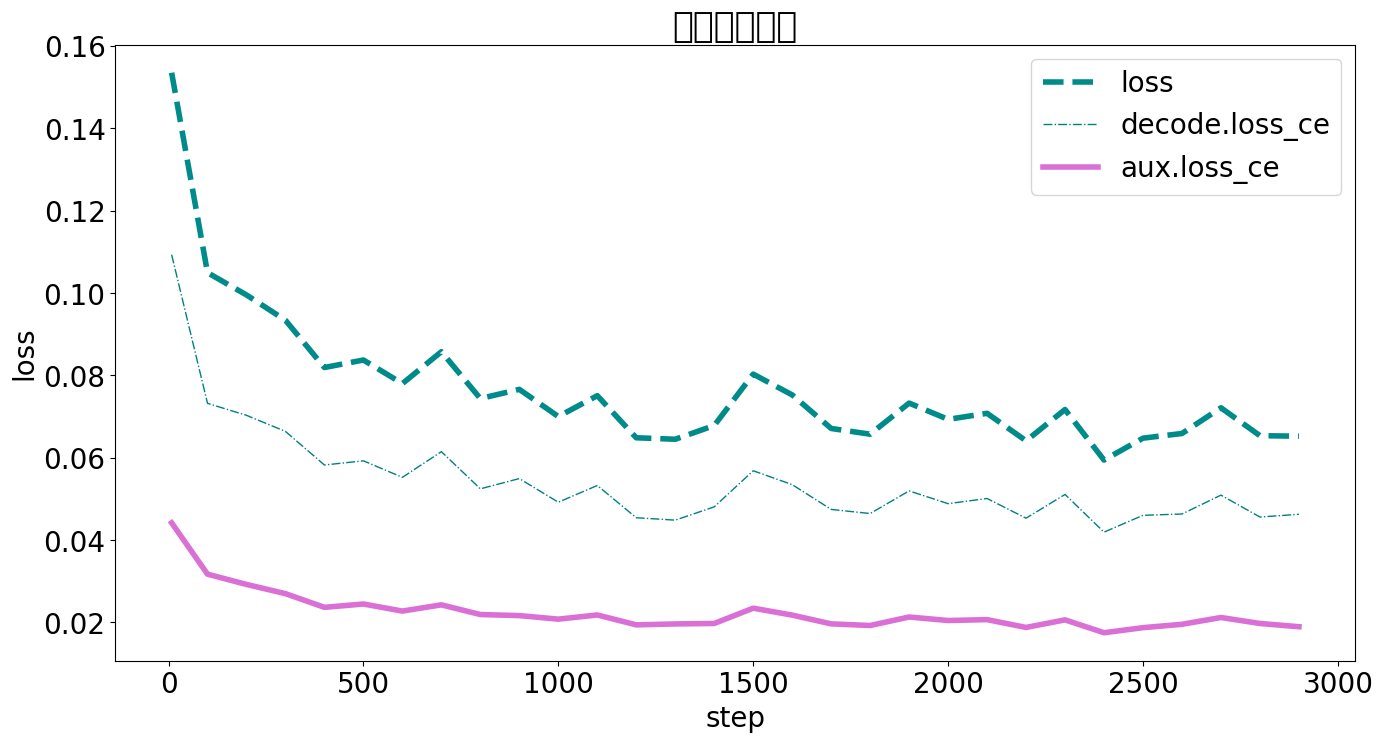

In [37]:
plt.figure(figsize=(16, 8))

x = df_train['step']
for y in metrics:
    plt.plot(x, df_train[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('训练集准确率', fontsize=25)
plt.savefig('训练集准确率.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

### 2.3 测试集评估指标

C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\3371817113.py:13: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  plt.savefig('测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\3371817113.py:13: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  plt.savefig('测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\3371817113.py:13: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from current font.
  plt.savefig('测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\3371817113.py:13: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  plt.savefig('测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')
C:\Users\wangt\AppData\Local\Temp\ipykernel_672804\3371817113.py:13: UserWarning: Glyph 20272 (\N{CJK UNIFIED IDEOGRAPH-4F30}) missing from 

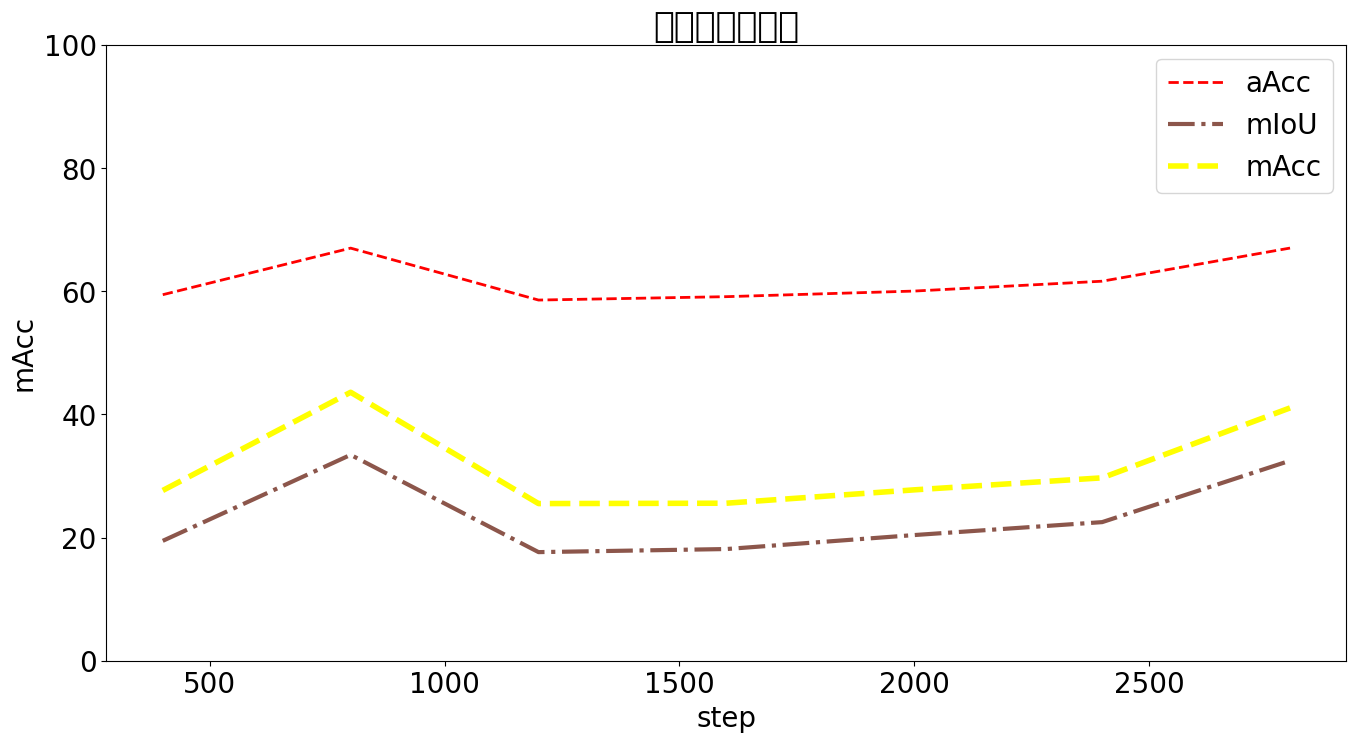

In [46]:
metrics = ['aAcc','mIoU','mAcc']
plt.figure(figsize=(16, 8))

x = df_test['step']
for y in metrics:
    plt.plot(x, df_test[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.ylim([0, 100])
plt.xlabel('step', fontsize=20)
plt.ylabel(y, fontsize=20)
plt.title('测试集评估指标', fontsize=25)
plt.savefig('测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

## Predict with Tained Result

In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

### 1. Load Config File

In [48]:
# 载入 config 配置文件
from mmengine import Config
cfg = Config.fromfile(r'D:\Tommy\++AI\mmseg\mmsegmentation\data\pspnet-DubaiDataset_20230612.py')
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

02/14 09:08:31 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: Quadro RTX 4000
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.55
    MSVC: n/a, reason: fileno
    PyTorch: 1.13.1
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192829337
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code

C:\Users\wangt\AppData\Local\anaconda3\envs\mmseg\lib\site-packages\mmengine\utils\manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
d:\tommy\++ai\mmseg\mmsegmentation\mmseg\models\backbones\resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
d:\tommy\++ai\mmseg\mmsegmentation\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
d:\tommy\++ai\mmseg\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is t

02/14 09:08:32 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/14 09:08:32 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

d:\tommy\++ai\mmseg\mmsegmentation\mmseg\engine\hooks\visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


### 2. Load Trained Model

In [49]:
checkpoint_path = r'D:\Tommy\++AI\mmseg\mmsegmentation\data\work_dirs\DubaiDataset\iter_3000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: D:\Tommy\++AI\mmseg\mmsegmentation\data\work_dirs\DubaiDataset\iter_3000.pth


### 3. Load new Image

In [50]:
img = mmcv.imread('Dubai-dataset/img_dir/val/71.jpg')

### 4. Segement Image

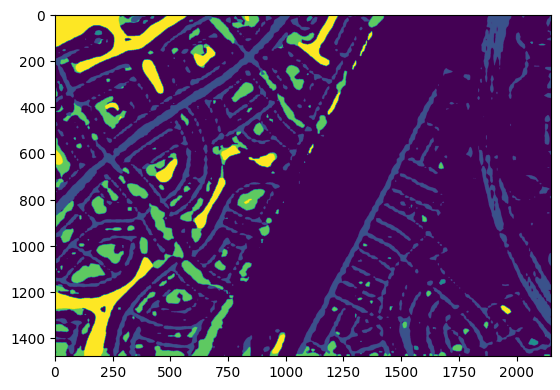

In [52]:
result = inference_model(model, img)
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
np.unique(pred_mask)
#array([0, 1, 2, 3, 4])
plt.imshow(pred_mask)
plt.show()

### 5. Visualize predicted result

C:\Users\wangt\AppData\Local\anaconda3\envs\mmseg\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


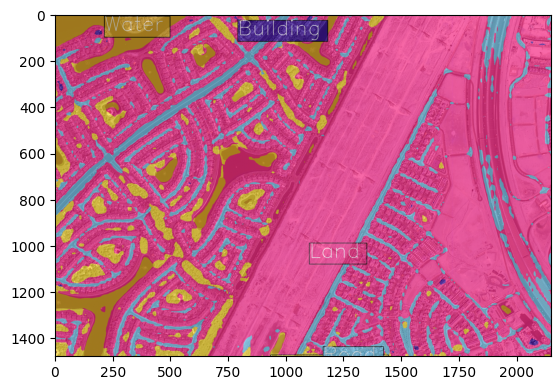

In [53]:
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

### 6. Find out  annoations from Original Dataset

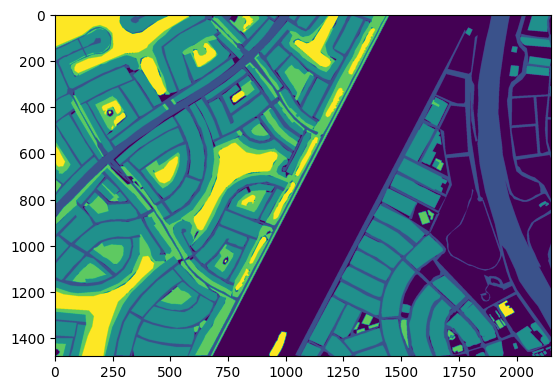

In [54]:
#获取测试集标注
label = mmcv.imread('Dubai-dataset/ann_dir/val/71.png')
label_mask = label[:,:,0]
np.unique(label_mask)
plt.imshow(label_mask)
plt.show()

### 7. Compare annotations between original and predicted 

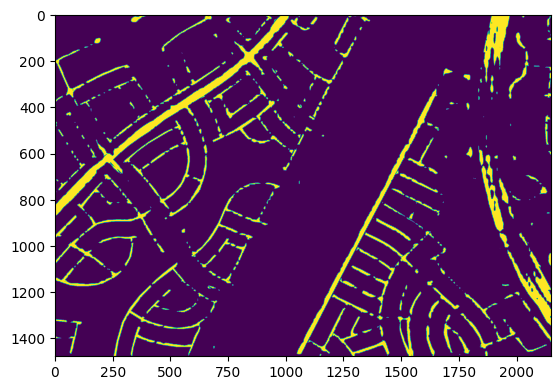

In [55]:
# 测试集标注

# 真实为前景，预测为前景
TP = (label_mask == 1) & (pred_mask==1)
# 真实为背景，预测为背景
TN = (label_mask == 0) & (pred_mask==0)
# 真实为前景，预测为背景
FN = (label_mask == 1) & (pred_mask==0)
# 真实为背景，预测为前景
FP = (label_mask == 0) & (pred_mask==1)
plt.imshow(TP)
plt.show()

### 8.confusion map

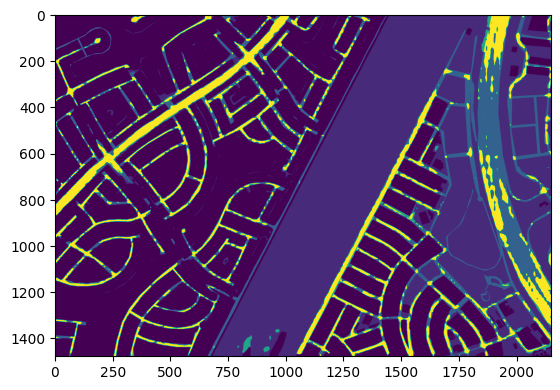

In [56]:
confusion_map = TP * 255 + FP * 150 + FN * 80 + TN * 30
plt.imshow(confusion_map)
plt.show()

### 9. confusion matrix

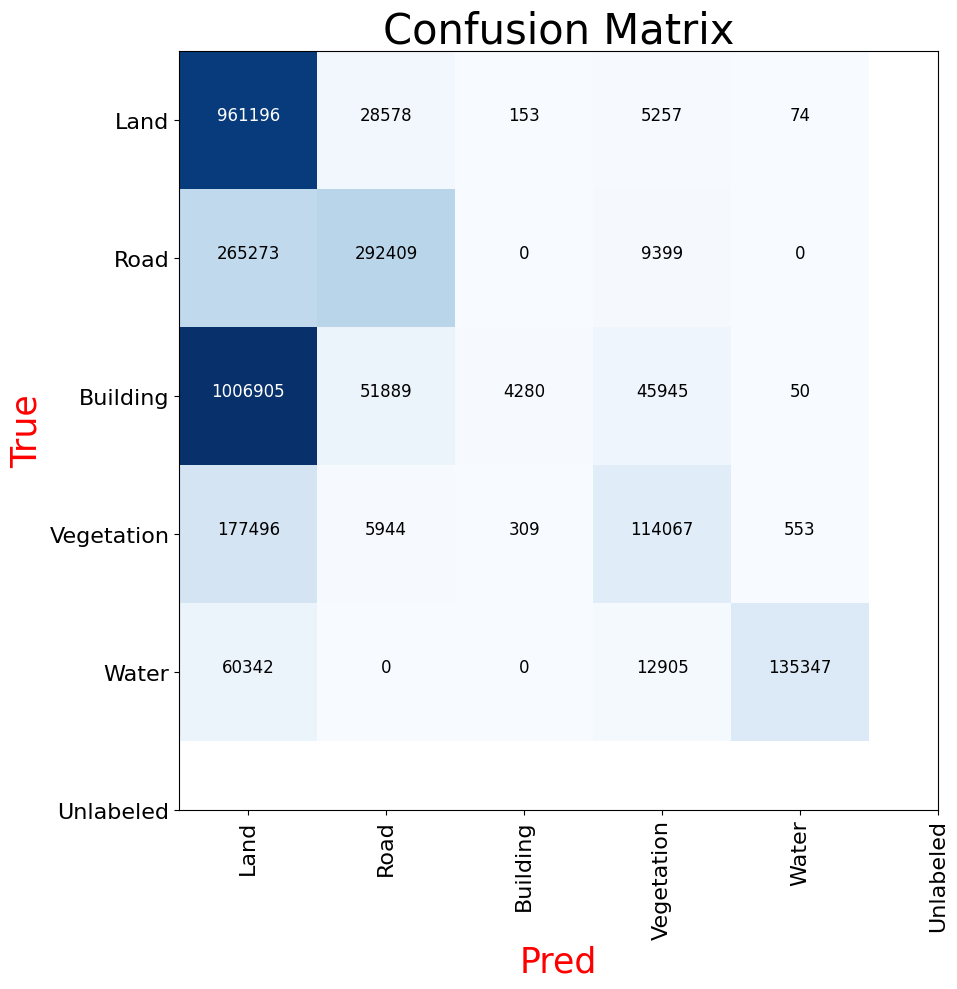

In [58]:
from sklearn.metrics import confusion_matrix
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())
confusion_matrix_model

import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()
classes = ['Land', 'Road', 'Building', 'Vegetation', 'Water', 'Unlabeled']
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

### 测试集性能评估
- 测试集精度指标
    - `python tools/test.py pspnet-DubaiDataset_20230612.py work_dirs/DubaiDataset/iter_3000.pth`
- 速度指标-FPS
    - `python tools/analysis_tools/benchmark.py pspnet-DubaiDataset_20230612.py work_dirs/DubaiDataset/iter_3000.pth`